The code below uses an LSTM model to predict trajectories.

Susanna Lange

In [ ]:
import pandas as pd
from pandas import read_csv
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import time as time
from sklearn.preprocessing import MinMaxScaler
import keras
from pandas import datetime
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout, RepeatVector, TimeDistributed, Masking
from keras import metrics


<ipython-input-147-ff54bf78bc5f>:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


Below are the code parameters currently used in the model. There are options to tune the model (or change the parameters slightly) to achieve better results. We will focus on those below:

In [ ]:
n_pre = 100  #number of time steps feeding in

#possible options: 100, 500, 1000, 2000

n_post = 10  #number of time steps predicting

#possible options(depends on n_pre as well): 10, 20, 50, 100 (can the model predict half the input sequence, or 1/3?)

window = 5 #this controls the amount of overlap between shifted sequences.

#possible options(depends on missing data, we don't want to shift our sequence and get a new sequence with no new info) 50, 100, 200

lr = 0.001 # learning rate

#learning rate can quickly change the model results! possible options: 0.01, 0.001, 0.0001, 0.00001

opt = keras.optimizers.RMSprop(learning_rate=lr)

#possible options = [keras.optimizers.Adam(learning_rate=lr), keras.optimizers.SGD(learning_rate=lr), keras.optimizers.RMSprop(learning_rate=lr)]

bs = 10 #batchsize

#possible options: 32, 64, 128, 256 (the larger the batch size, the quicker the code usually runs...)

epoch_number = 10 #number of epochs to train for

#posible options: 100, 500

hidden_neurons = 200 #neurons in the model

#possible options: 100, 200


## Model defined

In [ ]:
def create_model(steps_before, steps_after, hidden_neurons, opt):
    """
        creates, compiles and returns a RNN model
        @param steps_before: the number of previous time steps (input)
        @param steps_after: the number of posterior time steps (output or predictions)
        @param feature_count: the number of features in the model
        @param hidden_neurons: the number of hidden neurons per LSTM layer
    """
   # DROPOUT = 0.5
    LAYERS = 2

    model = Sequential()
    model.add(Masking(mask_value=-999))
    model.add(LSTM(hidden_neurons, input_shape = (steps_before, None),return_sequences=False))

    model.add(RepeatVector(steps_after))

    model.add(LSTM(hidden_neurons, return_sequences=True))
    model.add(TimeDistributed(Dense(8)))
    model.add(Activation('relu'))


    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

## Preprocessing Functions

In [ ]:
## additional preprocessing functions below
def delete_id(traj_data):
  del traj_data['trajectory_id']
  return traj_data


def daySeconds(x):
  """returns number of seconds since beginning of the day """
  return 3600*x.tm_hour+60*x.tm_min+x.tm_sec

def circularizeTime(traj_data):
  """This function translates the time data in the trajectory data from a string to a few numeric columns of a DataFrame
    The first column unix_time counts seconds from a fixed date Dec 31st, 1969.

    The columns day_clock_x and day_clock_y translate the 24 hours in a day into the position of the hand of a clock that completes a rotation once a day,
    this makes it easier for the network to observe trends that depend on the time of day.
    The columns year_clock_x and year_clock_y do the same if the hand of the clock completed a cycle once a year."""

  traj_data['unix_time'] = traj_data.apply(lambda traj:time.mktime(time.strptime(traj.time, '%Y-%m-%d %H:%M:%S')),axis=1)

  traj_data['year_day'] = traj_data.apply(lambda traj: time.strptime(traj.time,  '%Y-%m-%d %H:%M:%S').tm_yday,axis=1)
  traj_data['year_clock_x'] = traj_data.apply(lambda traj: np.cos(2*np.pi*traj.year_day/365), axis=1)
  traj_data['year_clock_y'] = traj_data.apply(lambda traj: np.sin(2*np.pi*traj.year_day/365), axis=1)
  del traj_data['year_day']


  traj_data['day_sec'] = traj_data.apply(lambda traj: daySeconds(time.strptime(traj.time,  '%Y-%m-%d %H:%M:%S')),axis=1)
  traj_data['day_clock_x'] = traj_data.apply(lambda traj: np.cos(2*np.pi*traj.day_sec/(24*60*60)),axis=1)
  traj_data['day_clock_y'] = traj_data.apply(lambda traj: np.sin(2*np.pi*traj.day_sec/(24*60*60)),axis=1)
  del traj_data['day_sec']
  scaler = MinMaxScaler(feature_range=(0, 1))
  traj_data[['unix_time']] = scaler.fit_transform(traj_data[['unix_time']])
  del traj_data['time']

  return traj_data

def mask_rows(df, time_interval, mask_val, mask_lst):
    #df['timestamp_minute'] = df['datetime'].map(lambda x: datetime_to_timestamp(x))
    time_format = '%Y-%m-%d %H:%M:%S'
    t = datetime.strptime(df.iloc[0].time, time_format)
    df['tdiff'] = df.time.map(lambda x: datetime.strptime(x, time_format)) - t
    df['tdiff_min'] = df.tdiff.map(lambda x: int(x.seconds/60))
    for i in range(len(df.tdiff_min)):
        if(df.tdiff_min[i] % time_interval != 0):
            for col in mask_lst:
                df[col][i] = mask_val
    df_new = df[['trajectory_id', 'time', 'lat','lon', 'temperature']]
    return df_new


Suppose we have 10 different trajectories we want to use to train the model. Then for each trajectory, we run it through the create_dataset function (which creates the staggered window of training and test data) and then join each together in a batch.

In [ ]:
def create_dataset(dataset, n_pre, n_post, window):
  """Creates training and testing data by shifting dependent on window input"""
  dX, dY = [], []
  for i in range(0, len(dataset)-n_pre-n_post, window):  #step size is controlled by window
    dX.append(dataset[i:i+n_pre])
    dY.append(dataset[i+n_pre:i+n_pre+n_post])
  return [np.array(dX)], [np.array(dY)]



In [ ]:
def create_batches(trajectories_array, n_pre, n_post, window):

  for i in range(0, len(trajectories_array)): #for each of the trajectories
      if i==0:
        dataX_batches, dataY_batches = create_dataset(trajectories_array[i], n_pre, n_post, window)
      if i != 0:
        dataX, dataY = create_dataset(trajectories_array[i], n_pre, n_post, window)
        dataX_batches = np.append(dataX_batches, dataX, axis=0)
        dataY_batches = np.append(dataY_batches, dataY, axis=0)
  if len(trajectories_array) == 1:
    dataX_batches = np.array(dataX_batches)

  (uniq_t,windowed,time,feat) = dataX_batches.shape
  dataX_batches = np.reshape(dataX_batches, (uniq_t*windowed,time,feat), order = 'C')
  dataY_batches = np.reshape(dataY_batches, (uniq_t*windowed,n_post,feat), order = 'C')

  return dataX_batches, dataY_batches



## Here we can load in the data and incorporate more preprocessing functions

In [ ]:
maine_simulation = pd.read_csv('trajectories_2020-01-01_seed222_500pts_maine.csv')


In [ ]:

maine_test = pd.read_csv('maine_test.csv')

In [ ]:
maine_simulation

,fishery,trajectory,time,lon,lat,temperature
0,Maine,1,2020-01-01 00:30:00,-58.592953,48.463047,0.882706
1,Maine,1,2020-01-01 01:30:00,-58.595852,48.463139,0.882706
2,Maine,1,2020-01-01 02:30:00,-58.598969,48.463295,0.893610
3,Maine,1,2020-01-01 03:30:00,-58.602364,48.463509,0.901265
4,Maine,1,2020-01-01 04:30:00,-58.606350,48.463844,0.912216
...,...,...,...,...,...,...
372495,Maine,500,2020-01-31 20:30:00,-59.887646,45.760792,-0.087964
372496,Maine,500,2020-01-31 21:30:00,-59.891205,45.751598,-0.084803
372497,Maine,500,2020-01-31 22:30:00,-59.895710,45.741566,-0.093399
372498,Maine,500,2020-01-31 23:30:00,-59.901463,45.730824,-0.093648


In [ ]:
maine_test

,fishery,datetime,longitude,latitude,water_temperature_mean,trajectory
0,Maine,2022-08-29 11:41:06,-68.073150,44.153595,14.0,1
1,Maine,2022-08-30 11:43:39,-68.073395,44.154070,14.0,1
2,Maine,2022-08-31 11:52:36,-68.073040,44.153603,14.0,1
3,Maine,2022-09-01 11:54:37,-68.072970,44.153587,15.0,1
4,Maine,2022-09-02 11:58:46,-68.073230,44.153824,14.0,1
...,...,...,...,...,...,...
109,Maine,2022-09-30 11:52:26,-68.073380,44.101097,13.0,1
110,Maine,2022-10-01 11:52:26,-68.073746,44.101190,13.0,1
111,Maine,2022-10-02 12:02:00,-68.074280,44.101370,12.0,1
112,Maine,2022-10-03 12:10:06,-68.073580,44.101050,12.0,1


In [ ]:
maine_simulation = maine_simulation.rename(columns = {'lat':'latitude', 'lon':'longitude', 'trajectory':'trajectory_id'})
maine_simulation.head()

,fishery,trajectory_id,time,longitude,latitude,temperature
0,Maine,1,2020-01-01 00:30:00,-58.592953,48.463047,0.882706
1,Maine,1,2020-01-01 01:30:00,-58.595852,48.463139,0.882706
2,Maine,1,2020-01-01 02:30:00,-58.598969,48.463295,0.893610
3,Maine,1,2020-01-01 03:30:00,-58.602364,48.463509,0.901265
4,Maine,1,2020-01-01 04:30:00,-58.606350,48.463844,0.912216


In [ ]:
maine_test = maine_test.rename(columns = {'water_temperature_mean':'temperature','trajectory':'trajectory_id', 'datetime':'time'})

In [ ]:
##REPLACE BELOW WITH OUR SIMULATED DATA
# load the dataset.

mock_traj = maine_simulation

###REPLACE THE BELOW WITH PREPROCESSING FUNCTIONS
# normalize the dataset.
scaler = MinMaxScaler(feature_range=(0, 1))
mock_traj[['latitude', 'longitude', 'temperature']] = scaler.fit_transform(mock_traj[['latitude', 'longitude','temperature']])
mock_traj

,fishery,trajectory_id,time,longitude,latitude,temperature
0,Maine,1,2020-01-01 00:30:00,0.770371,0.890325,0.126601
1,Maine,1,2020-01-01 01:30:00,0.770151,0.890334,0.126601
2,Maine,1,2020-01-01 02:30:00,0.769914,0.890350,0.127091
3,Maine,1,2020-01-01 03:30:00,0.769655,0.890371,0.127435
4,Maine,1,2020-01-01 04:30:00,0.769352,0.890405,0.127926
...,...,...,...,...,...,...
372495,Maine,500,2020-01-31 20:30:00,0.671855,0.618464,0.083018
372496,Maine,500,2020-01-31 21:30:00,0.671585,0.617539,0.083160
372497,Maine,500,2020-01-31 22:30:00,0.671242,0.616530,0.082774
372498,Maine,500,2020-01-31 23:30:00,0.670804,0.615449,0.082763


In [ ]:
mock_traj_test = maine_test

###REPLACE THE BELOW WITH PREPROCESSING FUNCTIONS
# normalize the dataset.
scaler = MinMaxScaler(feature_range=(0, 1))
mock_traj_test[['latitude', 'longitude', 'temperature']] = scaler.fit_transform(mock_traj_test[['latitude', 'longitude','temperature']])
mock_traj_test

,fishery,time,longitude,latitude,temperature,trajectory_id
0,Maine,2022-08-29 11:41:06,0.118245,0.993894,0.50,1
1,Maine,2022-08-30 11:43:39,0.116829,0.997259,0.50,1
2,Maine,2022-08-31 11:52:36,0.118881,0.993951,0.50,1
3,Maine,2022-09-01 11:54:37,0.119286,0.993837,0.75,1
4,Maine,2022-09-02 11:58:46,0.117783,0.995516,0.50,1
...,...,...,...,...,...,...
109,Maine,2022-09-30 11:52:26,0.116916,0.622016,0.25,1
110,Maine,2022-10-01 11:52:26,0.114801,0.622675,0.25,1
111,Maine,2022-10-02 12:02:00,0.111715,0.623950,0.00,1
112,Maine,2022-10-03 12:10:06,0.115760,0.621683,0.00,1


In [ ]:
mock_traj_test.head()

,fishery,time,longitude,latitude,temperature,trajectory_id
0,Maine,2022-08-29 11:41:06,0.118245,0.993894,0.50,1
1,Maine,2022-08-30 11:43:39,0.116829,0.997259,0.50,1
2,Maine,2022-08-31 11:52:36,0.118881,0.993951,0.50,1
3,Maine,2022-09-01 11:54:37,0.119286,0.993837,0.75,1
4,Maine,2022-09-02 11:58:46,0.117783,0.995516,0.50,1


In [ ]:
#from datetime import datetime
#mass_df = mask_rows(mass_df, 60, -999, ['latitude','longitude', 'temperature'])
mock_traj.head()

,fishery,trajectory_id,time,longitude,latitude,temperature
0,Maine,1,2020-01-01 00:30:00,0.770371,0.890325,0.126601
1,Maine,1,2020-01-01 01:30:00,0.770151,0.890334,0.126601
2,Maine,1,2020-01-01 02:30:00,0.769914,0.890350,0.127091
3,Maine,1,2020-01-01 03:30:00,0.769655,0.890371,0.127435
4,Maine,1,2020-01-01 04:30:00,0.769352,0.890405,0.127926


In [ ]:
del mock_traj['fishery']


In [ ]:
del mock_traj_test['fishery']

In [ ]:
## Functions to be used on a single trajectory
mock_traj = delete_id(mock_traj)

mock_traj = circularizeTime(mock_traj)
mock_traj_array = mock_traj.to_numpy() # this is still a single trajectory


In [ ]:
## Functions to be used on a single trajectory
mock_traj_test = delete_id(mock_traj_test)

mock_traj_test = circularizeTime(mock_traj_test)
mock_traj_array_test = mock_traj_test.to_numpy() # this is still a single trajectory


In [ ]:
mock_traj.shape

(372500, 8)

In [ ]:
#mock_traj_array = mock_traj.head(500)
mock_traj_array = np.reshape(mock_traj_array, (500, -1, 8), order = 'C')
# mock_traj_array2 = np.expand_dims(mock_traj_array, axis = 0)
# mock_traj_array2

In [ ]:
mock_traj_array_test.shape

(114, 8)

In [ ]:
mock_traj_array_test = np.reshape(mock_traj_array_test, (1, -1, 8), order = 'C')

In [ ]:
mock_traj_array.shape

(500, 745, 8)

In [ ]:
# # this is to be replaced with the collection of trajectories, the example below uses 5 (repeated mock_traj)
# mock_trajs_array = np.repeat([mock_traj_array], 500 , axis=0)
# mock_trajs_array.shape

In [ ]:
dataX_batches, dataY_batches = create_batches(mock_traj_array, n_pre, n_post, window)

In [ ]:
dataX_batches_test, dataY_batches_test = create_batches(mock_traj_array_test, n_pre, n_post, window)

## Here is where we train the model

In [ ]:
# create and fit the LSTM network
EPOCHS = epoch_number
print('creating model...')
model = create_model(n_pre, n_post, hidden_neurons,opt)


creating model...


In [ ]:
#perhaps create validation data separately rather than as part of training....currently biased (should be less biased when with more data)
history = model.fit(dataX_batches, dataY_batches, batch_size=bs, epochs=epoch_number, validation_split=0.2)

Epoch 1/10
5080/5080 [==============================] - 990s 193ms/step - loss: 0.0651 - val_loss: 0.0633
Epoch 2/10
5080/5080 [==============================] - 937s 184ms/step - loss: 0.0633 - val_loss: 0.0632
Epoch 3/10
5080/5080 [==============================] - 931s 183ms/step - loss: 0.0632 - val_loss: 0.0631
Epoch 4/10
5080/5080 [==============================] - 931s 183ms/step - loss: 0.0632 - val_loss: 0.0632
Epoch 5/10
5080/5080 [==============================] - 931s 183ms/step - loss: 0.0631 - val_loss: 0.0631
Epoch 6/10
5080/5080 [==============================] - 986s 194ms/step - loss: 0.0631 - val_loss: 0.0631
Epoch 7/10
5080/5080 [==============================] - 963s 190ms/step - loss: 0.0631 - val_loss: 0.0631
Epoch 8/10
5080/5080 [==============================] - 958s 189ms/step - loss: 0.0631 - val_loss: 0.0631
Epoch 9/10
5080/5080 [==============================] - 968s 191ms/step - loss: 0.0631 - val_loss: 0.0631
Epoch 10/10
5080/5080 [=======================

In [ ]:
import math

In [ ]:


model.save('my_model.h5')

In [ ]:
from keras.models import load_model

In [ ]:
model = keras.models.load_model('my_model.h5')

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
trainScore = model.evaluate(dataX_batches, dataY_batches, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))


Train Score: 0.06 MSE (0.25 RMSE)


In [ ]:
testScore = model.evaluate(dataX_batches_test, dataY_batches_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Test Score: 0.76 MSE (0.87 RMSE)


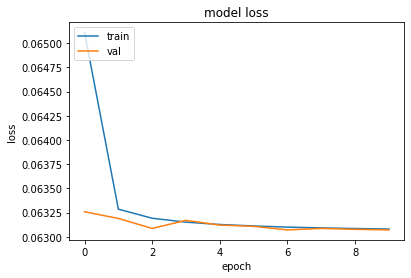

In [ ]:
#for plotting loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Example of using the model to predict a single trajectory

In [ ]:
#Send a single trajectory through the model using model.predict
y=np.expand_dims(dataX_batches_test[0], axis=0)
predict = model.predict(y)


1/1 [==============================] - 0s 37ms/step


In [ ]:
vars(model)

{'_self_setattr_tracking': True,
 '_is_model_for_instrumentation': True,
 '_instrumented_keras_api': True,
 '_instrumented_keras_layer_class': False,
 '_instrumented_keras_model_class': True,
 '_trainable': True,
 '_stateful': False,
 'built': True,
 '_input_spec': None,
 '_build_input_shape': TensorShape([None, None, 8]),
 '_saved_model_inputs_spec': TensorSpec(shape=(None, None, 8), dtype=tf.float32, name='masking_input'),
 '_saved_model_arg_spec': ([TensorSpec(shape=(None, None, 8), dtype=tf.float32, name='masking_input')],
  {}),
 '_supports_masking': True,
 '_name': 'sequential',
 '_activity_regularizer': None,
 '_trainable_weights': [],
 '_non_trainable_weights': [],
 '_updates': [],
 '_thread_local': <_thread._local at 0x7f339b6d04f0>,
 '_callable_losses': [],
 '_losses': [],
 '_metrics': [],
 '_metrics_lock': <unlocked _thread.lock object at 0x7f339cca8180>,
 '_dtype_policy': <Policy "float32">,
 '_compute_dtype_object': tf.float32,
 '_autocast': False,
 '_self_tracked_trackabl

The results of predict above, are the predicted trajectories. To see them, we need to transform back to un-normalized results. The code below prints the input y, the actual next 10 steps, and the predicted next 10 steps.

In [ ]:
dataframe_traj=pd.DataFrame(dataX_batches_test[0], columns=['lat', 'long', 'temp','unix_time', 'year_clock_x', 'year_clock_y', 'day_clock_x', 'day_clock_y'])

dataframe_traj[['lat', 'long', 'temp']] = scaler.inverse_transform(dataframe_traj[['lat', 'long','temp']])


predict_traj = np.squeeze(predict)
dataframe_predict=pd.DataFrame(predict_traj , columns=['lat', 'long', 'temp','unix_time', 'year_clock_x', 'year_clock_y', 'day_clock_x', 'day_clock_y'])
dataframe_predict[['lat', 'long', 'temp']] = scaler.inverse_transform(dataframe_predict[['lat', 'long','temp']])


dataframe_traj_actual=pd.DataFrame(dataY_batches_test[0], columns=['lat', 'long', 'temp','unix_time', 'year_clock_x', 'year_clock_y', 'day_clock_x', 'day_clock_y'])

dataframe_traj_actual[['lat', 'long', 'temp']] = scaler.inverse_transform(dataframe_traj_actual[['lat', 'long','temp']])



In [ ]:
dataframe_traj_actual

,lat,long,temp,unix_time,year_clock_x,year_clock_y,day_clock_x,day_clock_y
0,44.154457,-67.974506,13.0,0.686899,-0.133015,-0.991114,0.124612,0.992206
1,44.038444,-67.971559,13.0,0.689227,-0.133015,-0.991114,-0.391133,0.920334
2,44.038310,-67.971287,13.0,0.717285,-0.115935,-0.993257,-0.452046,0.891995
3,44.038685,-67.971712,13.0,0.745083,-0.098820,-0.995105,-0.459554,0.888150
4,44.038734,-67.971773,13.0,0.772870,-0.081676,-0.996659,-0.464649,0.885495
5,44.039060,-67.971908,13.0,0.800647,-0.064508,-0.997917,-0.467930,0.883766
6,44.031249,-67.984112,13.0,0.805275,-0.064508,-0.997917,-0.999331,0.036571
7,44.028846,-67.984729,13.0,0.833032,-0.047321,-0.998880,-0.999304,0.037298
8,44.029099,-67.985333,13.0,0.860800,-0.030120,-0.999546,-0.999355,0.035917
9,44.029792,-67.985983,13.0,0.888574,-0.012910,-0.999917,-0.999455,0.033010


In [ ]:
print('This is the trajectory we fed into the model')
dataframe_traj

This is the trajectory we fed into the model


,lat,long,temp,unix_time,year_clock_x,year_clock_y,day_clock_x,day_clock_y
0,44.029980,-67.921637,14.0,0.000000,-0.534373,-0.845249,-0.996602,0.082373
1,44.029780,-67.921054,14.0,0.027810,-0.519744,-0.854322,-0.997456,0.071280
2,44.030069,-67.921627,14.0,0.055744,-0.504961,-0.863142,-0.999479,0.032283
3,44.030127,-67.921646,15.0,0.083544,-0.490029,-0.871706,-0.999724,0.023487
4,44.029914,-67.921356,14.0,0.111385,-0.474951,-0.880012,-0.999986,0.005381
...,...,...,...,...,...,...,...,...
95,44.038837,-67.971778,14.0,0.559300,-0.217723,-0.976011,-0.667129,-0.744943
96,44.038489,-67.971657,13.0,0.587077,-0.200891,-0.979614,-0.664416,-0.747363
97,44.038922,-67.971964,13.0,0.615010,-0.183998,-0.982927,-0.634731,-0.772734
98,44.039154,-67.972092,13.0,0.642832,-0.167052,-0.985948,-0.624050,-0.781384


In [ ]:
dataframe_predict

,lat,long,temp,unix_time,year_clock_x,year_clock_y,day_clock_x,day_clock_y
0,44.093422,-67.957359,16.944042,0.240214,0.964702,0.167909,0.000000,0.0
1,44.109974,-67.942268,17.237318,0.340546,1.100563,0.177091,0.000000,0.0
2,44.106186,-67.954620,16.552643,0.359788,1.066807,0.166115,0.000000,0.0
3,44.103100,-67.959129,16.392170,0.332597,1.043772,0.158903,0.000000,0.0
4,44.102013,-67.957466,16.445591,0.301775,1.046496,0.164725,0.137142,0.0
5,44.100227,-67.956566,16.456039,0.283392,1.044364,0.172277,0.497844,0.0
6,44.097935,-67.957214,16.457302,0.270339,1.027979,0.167866,0.759323,0.0
7,44.095490,-67.958046,16.475407,0.257524,1.004362,0.153930,0.939646,0.0
8,44.093086,-67.958641,16.512207,0.244239,0.979166,0.137264,1.064386,0.0
9,44.090790,-67.959076,16.569386,0.230909,0.954993,0.122809,1.146435,0.0


In [ ]:
print('This is predicted next steps')
dataframe_predict.to_csv('maine_predicted_test.csv',index = False)

This is predicted next steps


In [ ]:
print('These are the actual steps')
dataframe_traj_actual.to_csv('maine_actual_test.csv', index = False)

These are the actual steps
